# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

import helpers3 

from sklearn.preprocessing import MinMaxScaler

#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio_raw_df = pd.DataFrame(portfolio)
profile_raw_df = pd.DataFrame(profile)
transcript_raw_df = pd.DataFrame(transcript)

# ANALYSIS
## Data Exploration - Portfolio

In [3]:
portfolio_raw_df

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Porfolio after data exploration:**

with the following rules for the offert label:
* 1 for informational
* 2 for discount
* 3 for BOGO

In [4]:
# store the conversion in the following dictionaries
offer_dict = {'informational' : 1, 'discount' : 2, 'bogo' :3}
offer_id_dict = {'ae264e3637204a6fb9bb56bc8210ddfd' : 1,
                 '4d5c57ea9a6940dd891ad53e9dbe8da0' : 2,
                 '3f207df678b143eea3cee63160fa8bed' : 3,
                 '9b98b8c7a33c4b65b9aebfe6a799e6d9' : 4,
                 '0b1e1539f2cc45b7b9fa7c272da2e1d7' : 5,
                 '2298d6c36e964ae4a3e7e9706d1fb8c2' : 6,
                 'fafdcd668e3743c1bb461111dcafc2a4' : 7,
                 '5a8bc65990b245e5a138643cd4eb9837' : 8,
                 'f19421c1d4aa40978ebb69ca19b0e20d' : 9,
                 '2906b810c7d4411798c6938adc9daaa5' : 10}

In [5]:
portfolio_clean_df = helpers3.portfolio_exploration(portfolio_raw_df)
portfolio_clean_df

,reward,difficulty,duration,offer_type,web,email,mobile,social
1,10,10,7,3,0,1,1,1
2,10,10,5,3,1,1,1,1
3,0,0,4,1,1,1,1,0
4,5,5,7,3,1,1,1,0
5,5,20,10,2,1,1,0,0
6,3,7,7,2,1,1,1,1
7,2,10,10,2,1,1,1,1
8,0,0,3,1,0,1,1,1
9,5,5,5,3,1,1,1,1
10,2,10,7,2,1,1,1,0


In [6]:
portfolio_clean_df.describe()

,reward,difficulty,duration,offer_type,web,email,mobile,social
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,4.200000,7.700000,6.500000,2.200000,0.800000,1.0,0.900000,0.600000
std,3.583915,5.831905,2.321398,0.788811,0.421637,0.0,0.316228,0.516398
min,0.000000,0.000000,3.000000,1.000000,0.000000,1.0,0.000000,0.000000
25%,2.000000,5.000000,5.000000,2.000000,1.000000,1.0,1.000000,0.000000
50%,4.000000,8.500000,7.000000,2.000000,1.000000,1.0,1.000000,1.000000
75%,5.000000,10.000000,7.000000,3.000000,1.000000,1.0,1.000000,1.000000
max,10.000000,20.000000,10.000000,3.000000,1.000000,1.0,1.000000,1.000000


## Data Exploration - Profile

In [7]:
profile_raw_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


**Profile after data exploration:**


In [9]:
profile_df = pd.DataFrame(profile)

# store the conversion in the following dictionaries
gender_dict = {'None' : 0, 'O' : 1, 'F' : 2, 'M' : 3}
profile_id_dict = {}
index = np.arange(len(profile_df))
for i in range(len(index)):
    profile_id_dict[profile_df['id'][i]] = i
#profile_id_dict

In [10]:
profile_clean_df = helpers3.profile_exploration(profile_raw_df)
profile_clean_df.head()

,gender,age,became_member_on,income
0,0,118,20170212,65404.991568
1,2,55,20170715,112000.000000
2,0,118,20180712,65404.991568
3,2,75,20170509,100000.000000
4,0,118,20170804,65404.991568


In [11]:
profile_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            17000 non-null  int64  
 1   age               17000 non-null  int64  
 2   became_member_on  17000 non-null  int64  
 3   income            17000 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 531.4 KB


## Data Exploration - Transcript

In [12]:
transcript_raw_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
transcript_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [14]:
transcript_raw_df[transcript_raw_df['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [15]:
# Identify the type of keys in the column value
key_dict ={}

for i in range(len(transcript_raw_df['value'])):
    for key in transcript_raw_df['value'][i]:
        key_dict[key] = 0
key_dict

{'offer id': 0, 'amount': 0, 'offer_id': 0, 'reward': 0}

**Cleaning of the value column**

In [16]:
transcript_value_clean_df = helpers3.transcript_value_exploration(transcript_raw_df,offer_id_dict, profile_id_dict)
transcript_value_clean_df.head()

,pers-offer-time,person,event,time,offer id,amount,reward,pers-offer
0,3-4-0,3,offer received,0,4,0.0,0,3-4
1,4-5-0,4,offer received,0,5,0.0,0,4-5
2,5-10-0,5,offer received,0,10,0.0,0,5-10
3,6-7-0,6,offer received,0,7,0.0,0,6-7
4,7-2-0,7,offer received,0,2,0.0,0,7-2


In [17]:
transcript_value_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pers-offer-time  306534 non-null  object 
 1   person           306534 non-null  int64  
 2   event            306534 non-null  object 
 3   time             306534 non-null  int64  
 4   offer id         306534 non-null  int64  
 5   amount           306534 non-null  float64
 6   reward           306534 non-null  int64  
 7   pers-offer       306534 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 18.7+ MB


In [18]:
transcript_value_clean_df[transcript_value_clean_df['person'] == 3]

,pers-offer-time,person,event,time,offer id,amount,reward,pers-offer
0,3-4-0,3,offer received,0,4,0.00,0,3-4
15561,3-4-6,3,offer viewed,6,4,0.00,0,3-4
47582,3-0-132,3,transaction,132,0,19.89,0,3-0
47583,3-4-132,3,offer completed,132,4,0.00,5,3-4
49502,3-0-144,3,transaction,144,0,17.78,0,3-0
53176,3-8-168,3,offer received,168,8,0.00,0,3-8
85291,3-8-216,3,offer viewed,216,8,0.00,0,3-8
87134,3-0-222,3,transaction,222,0,19.67,0,3-0
92104,3-0-240,3,transaction,240,0,29.72,0,3-0
141566,3-0-378,3,transaction,378,0,23.93,0,3-0


**Check if a transaction is linked to an offer or not**

In [19]:
transcript_transaction_clean_df = helpers3.transcript_transaction_exploration(transcript_value_clean_df)

In [20]:
transcript_transaction_clean_df[(transcript_transaction_clean_df['person'] == 3)]

,pers-offer-time,person,event,time,offer id,amount,reward,pers-offer
0,3-4-0,3,offer received,0,4,0.00,0,3-4
15561,3-4-6,3,offer viewed,6,4,0.00,0,3-4
47582,3-0-132,3,transaction linked,132,0,19.89,0,3-4
47583,3-4-132,3,offer completed,132,4,19.89,5,3-4
49502,3-0-144,3,transaction,144,0,17.78,0,3-0
53176,3-8-168,3,offer received,168,8,0.00,0,3-8
85291,3-8-216,3,offer viewed,216,8,0.00,0,3-8
87134,3-0-222,3,transaction,222,0,19.67,0,3-0
92104,3-0-240,3,transaction,240,0,29.72,0,3-0
141566,3-0-378,3,transaction,378,0,23.93,0,3-0


**Check if a an event can be have the same id pers-offer**

In [21]:
duplicate = transcript_transaction_clean_df[transcript_transaction_clean_df.duplicated(['pers-offer', 'event'])]
duplicate.head()

,pers-offer-time,person,event,time,offer id,amount,reward,pers-offer
15565,41-0-6,41,transaction,6,0,1.44,0,41-0
15771,1451-0-6,1451,transaction,6,0,4.63,0,1451-0
15882,2227-0-6,2227,transaction,6,0,1.30,0,2227-0
16029,3244-0-6,3244,transaction,6,0,3.52,0,3244-0
16087,3638-0-6,3638,transaction,6,0,4.11,0,3638-0


In [22]:
duplicate_dict = {'offer received' : 0, 'offer viewed' : 0, 'offer completed' : 0, 'transaction' :0, 'transaction linked' :0,}

for i in duplicate['event']:
    duplicate_dict[i] = duplicate_dict[i] + 1
duplicate_dict.values()

dict_values([12989, 8590, 4583, 92180, 3746])

**Final transcript exploration**

In [23]:
transcript_clean_df = helpers3.transcript_final_exploration(transcript_transaction_clean_df)
transcript_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171624 entries, 0 to 171623
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   pers-offer-time          171624 non-null  object 
 1   received                 171624 non-null  int64  
 2   viewed                   171624 non-null  int64  
 3   completed                171624 non-null  int64  
 4   completed before viewed  171624 non-null  int64  
 5   amount                   171624 non-null  float64
 6   reward                   171624 non-null  int64  
 7   person                   171624 non-null  int64  
 8   offer                    171624 non-null  int64  
 9   pers-offer               171624 non-null  object 
dtypes: float64(1), int64(7), object(2)
memory usage: 13.1+ MB


In [24]:
transcript_clean_df.describe()

,received,viewed,completed,completed before viewed,amount,reward,person,offer
count,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000
mean,1.075683,0.967586,0.826895,0.058267,10.345010,0.959516,8506.400900,2.023954
std,0.292764,0.375607,0.448551,0.255520,27.681194,2.697818,4900.617759,3.170195
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.700000,0.000000,4274.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,4.890000,0.000000,8517.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,15.320000,0.000000,12735.000000,4.000000
max,5.000000,5.000000,4.000000,3.000000,1062.280000,40.000000,16999.000000,10.000000


In [25]:
transcript_clean_df[transcript_clean_df['person'] == 3]

,pers-offer-time,received,viewed,completed,completed before viewed,amount,reward,person,offer,pers-offer
0,3-4-0,1,1,1,0,19.89,5,3,4,3-4
30959,3-0-144,1,1,1,0,17.78,0,3,0,3-0-49502
33917,3-8-168,1,1,0,0,0.00,0,3,8,3-8
52919,3-0-222,1,1,1,0,19.67,0,3,0,3-0-87134
55926,3-0-240,1,1,1,0,29.72,0,3,0,3-0-92104
86242,3-0-378,1,1,1,0,23.93,0,3,0,3-0-141566
91333,3-1-408,1,1,1,0,10.86,10,3,1,3-1
117943,3-9-504,1,1,1,1,10.86,5,3,9,3-9
131907,3-0-534,1,1,1,0,26.56,0,3,0,3-0-230412


In [26]:
duplicatetest = transcript_clean_df[transcript_clean_df.duplicated('pers-offer-time')]
duplicatetest

,pers-offer-time,received,viewed,completed,completed before viewed,amount,reward,person,offer,pers-offer


**Merge of portfolio, profile and transcript file**

In [27]:
merged_data_df = transcript_clean_df
merged_data_df.set_index("pers-offer-time", inplace = True)
merged_data_df.head()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,pers-offer
pers-offer-time,,,,,,,,,
3-4-0,1,1,1,0,19.89,5,3,4,3-4
4-5-0,3,2,0,0,0.00,0,4,5,4-5
5-10-0,1,1,0,0,0.00,0,5,10,5-10
6-7-0,2,2,0,0,0.00,0,6,7,6-7
7-2-0,1,1,0,0,0.00,0,7,2,7-2


In [28]:
merged_data_df = helpers3.merge_with_portfolio(merged_data_df, portfolio_clean_df)
merged_data_df = helpers3.merge_with_profile(merged_data_df, profile_clean_df)

In [29]:
merged_data_df.head()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,pers-offer,difficulty,duration,offer_type,web,email,mobile,social,age,became member on,gender,income
pers-offer-time,,,,,,,,,,,,,,,,,,,,
3-4-0,1,1,1,0,19.89,5,3,4,3-4,5,7,3,1,1,1,0,75,20170509,2,100000.000000
4-5-0,3,2,0,0,0.00,5,4,5,4-5,20,10,2,1,1,0,0,118,20170804,0,65404.991568
5-10-0,1,1,0,0,0.00,2,5,10,5-10,10,7,2,1,1,1,0,68,20180426,3,70000.000000
6-7-0,2,2,0,0,0.00,2,6,7,6-7,10,10,2,1,1,1,1,118,20170925,0,65404.991568
7-2-0,1,1,0,0,0.00,10,7,2,7-2,10,5,3,1,1,1,1,118,20171002,0,65404.991568


In [30]:
merged_data_df.describe()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,difficulty,duration,offer_type,web,email,mobile,social,age,became member on,gender,income
count,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.00000,171624.000000,171624.000000,171624.000000,1.716240e+05,171624.000000,171624.000000
mean,1.075683,0.967586,0.826895,0.058267,10.345010,1.551088,8506.400900,2.023954,2.843716,2.398715,0.811343,0.294796,0.36876,0.331620,0.221082,61.104880,2.016501e+07,2.252004,62176.410900
std,0.292764,0.375607,0.448551,0.255520,27.681194,2.896293,4900.617759,3.170195,5.016636,3.411744,1.154693,0.455952,0.48247,0.470797,0.414977,27.497056,1.220915e+04,0.991409,19361.583575
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,18.000000,2.013073e+07,0.000000,30000.000000
25%,1.000000,1.000000,1.000000,0.000000,0.700000,0.000000,4274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,42.000000,2.016023e+07,2.000000,48000.000000
50%,1.000000,1.000000,1.000000,0.000000,4.890000,0.000000,8517.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,57.000000,2.017033e+07,3.000000,64000.000000
75%,1.000000,1.000000,1.000000,0.000000,15.320000,2.000000,12735.000000,4.000000,5.000000,5.000000,2.000000,1.000000,1.00000,1.000000,0.000000,72.000000,2.017112e+07,3.000000,72000.000000
max,5.000000,5.000000,4.000000,3.000000,1062.280000,10.000000,16999.000000,10.000000,20.000000,10.000000,3.000000,1.000000,1.00000,1.000000,1.000000,118.000000,2.018073e+07,3.000000,120000.000000


In [31]:
merged_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171624 entries, 3-4-0 to 16994-0-714
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   received                 171624 non-null  int64  
 1   viewed                   171624 non-null  int64  
 2   completed                171624 non-null  int64  
 3   completed before viewed  171624 non-null  int64  
 4   amount                   171624 non-null  float64
 5   reward                   171624 non-null  int64  
 6   person                   171624 non-null  int64  
 7   offer                    171624 non-null  int64  
 8   pers-offer               171624 non-null  object 
 9   difficulty               171624 non-null  int64  
 10  duration                 171624 non-null  int64  
 11  offer_type               171624 non-null  int64  
 12  web                      171624 non-null  int64  
 13  email                    171624 non-null  int64  
 14  

In [32]:
# For the explonatory visualisation, we save the dataframe before the normalization
plot_data_df = merged_data_df.copy(deep=True)

In [33]:
# Normalisatio of the data

columns_to_scale = ['difficulty', 'duration', 'reward', 'amount', 'age', 'became member on', 'income']
scaler = MinMaxScaler()


for col in columns_to_scale:
    scaled_col = np.array(merged_data_df[col]).reshape(-1,1)
    scaled_col = scaler.fit_transform(scaled_col)
    merged_data_df[col] = scaled_col

In [34]:
merged_data_df.describe()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,difficulty,duration,offer_type,web,email,mobile,social,age,became member on,gender,income
count,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.00000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000
mean,1.075683,0.967586,0.826895,0.058267,0.009738,0.155109,8506.400900,2.023954,0.142186,0.239871,0.811343,0.294796,0.36876,0.331620,0.221082,0.431049,0.685619,2.252004,0.357516
std,0.292764,0.375607,0.448551,0.255520,0.026058,0.289629,4900.617759,3.170195,0.250832,0.341174,1.154693,0.455952,0.48247,0.470797,0.414977,0.274971,0.244198,0.991409,0.215129
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000659,0.000000,4274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.240000,0.590035,2.000000,0.200000
50%,1.000000,1.000000,1.000000,0.000000,0.004603,0.000000,8517.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.390000,0.792008,3.000000,0.377778
75%,1.000000,1.000000,1.000000,0.000000,0.014422,0.200000,12735.000000,4.000000,0.250000,0.500000,2.000000,1.000000,1.00000,1.000000,0.000000,0.540000,0.807908,3.000000,0.466667
max,5.000000,5.000000,4.000000,3.000000,1.000000,1.000000,16999.000000,10.000000,1.000000,1.000000,3.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000


In [35]:
# remove the transaction from the merged data
merged_data_witout_transaction_df = merged_data_df[merged_data_df['offer_type'] != 0]

merged_data_witout_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63288 entries, 3-4-0 to 16998-1-576
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   received                 63288 non-null  int64  
 1   viewed                   63288 non-null  int64  
 2   completed                63288 non-null  int64  
 3   completed before viewed  63288 non-null  int64  
 4   amount                   63288 non-null  float64
 5   reward                   63288 non-null  float64
 6   person                   63288 non-null  int64  
 7   offer                    63288 non-null  int64  
 8   pers-offer               63288 non-null  object 
 9   difficulty               63288 non-null  float64
 10  duration                 63288 non-null  float64
 11  offer_type               63288 non-null  int64  
 12  web                      63288 non-null  int64  
 13  email                    63288 non-null  int64  
 14  mobile           

**Creation of pers_offer_df, class_df and data_input_df**

In [36]:
class_list = list()

for i in range(len(merged_data_witout_transaction_df['offer'])) :
    if merged_data_witout_transaction_df['completed'][i] > merged_data_witout_transaction_df['completed before viewed'][i]:
        class_list.append(1)
    else:
        class_list.append(0)
        
class_df = pd.DataFrame(class_list, columns = ['Class'])
class_df.index = merged_data_witout_transaction_df.index

class_df.head()

,Class
pers-offer-time,
3-4-0,1
4-5-0,0
5-10-0,0
6-7-0,0
7-2-0,0


In [37]:
drop = ["amount" , "reward", "difficulty", "duration", "web", "email", "mobile", "social", "age", "became member on", "income" ]
pers_offer_df = merged_data_witout_transaction_df.drop(columns = drop)

pers_offer_df.head()

,received,viewed,completed,completed before viewed,person,offer,pers-offer,offer_type,gender
pers-offer-time,,,,,,,,,
3-4-0,1,1,1,0,3,4,3-4,3,2
4-5-0,3,2,0,0,4,5,4-5,2,0
5-10-0,1,1,0,0,5,10,5-10,2,3
6-7-0,2,2,0,0,6,7,6-7,2,0
7-2-0,1,1,0,0,7,2,7-2,3,0


In [38]:
drop = ["received" , "viewed", "completed", "completed before viewed", "person", "offer", "pers-offer", "offer_type", "gender"]
data_input_df = merged_data_witout_transaction_df.drop(columns = drop)

data_input_df.head()

,amount,reward,difficulty,duration,web,email,mobile,social,age,became member on,income
pers-offer-time,,,,,,,,,,,
3-4-0,0.018724,0.5,0.25,0.7,1,1,1,0,0.57,0.795648,0.777778
4-5-0,0.000000,0.5,1.00,1.0,1,1,0,0,1.00,0.801548,0.393389
5-10-0,0.000000,0.2,0.50,0.7,1,1,1,0,0.50,0.994000,0.444444
6-7-0,0.000000,0.2,0.50,1.0,1,1,1,1,1.00,0.803968,0.393389
7-2-0,0.000000,1.0,0.50,0.5,1,1,1,1,1.00,0.805508,0.393389


In [39]:
data_input_df.describe()

,amount,reward,difficulty,duration,web,email,mobile,social,age,became member on,income
count,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,0.009172,0.420623,0.385579,0.650482,0.799425,1.0,0.899286,0.599529,0.444621,0.726655,0.393230
std,0.027565,0.340291,0.277074,0.220356,0.400434,0.0,0.300952,0.489998,0.267300,0.233756,0.224459
min,0.000000,0.000000,0.000000,0.300000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.200000,0.250000,0.500000,1.000000,1.0,1.000000,0.000000,0.270000,0.595976,0.233333
50%,0.000000,0.500000,0.500000,0.700000,1.000000,1.0,1.000000,1.000000,0.400000,0.801508,0.393389
75%,0.013735,0.500000,0.500000,0.700000,1.000000,1.0,1.000000,1.000000,0.550000,0.810069,0.511111
max,0.973171,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploratory Visualization

In [40]:
plot_data_df.describe()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,difficulty,duration,offer_type,web,email,mobile,social,age,became member on,gender,income
count,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.00000,171624.000000,171624.000000,171624.000000,1.716240e+05,171624.000000,171624.000000
mean,1.075683,0.967586,0.826895,0.058267,10.345010,1.551088,8506.400900,2.023954,2.843716,2.398715,0.811343,0.294796,0.36876,0.331620,0.221082,61.104880,2.016501e+07,2.252004,62176.410900
std,0.292764,0.375607,0.448551,0.255520,27.681194,2.896293,4900.617759,3.170195,5.016636,3.411744,1.154693,0.455952,0.48247,0.470797,0.414977,27.497056,1.220915e+04,0.991409,19361.583575
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,18.000000,2.013073e+07,0.000000,30000.000000
25%,1.000000,1.000000,1.000000,0.000000,0.700000,0.000000,4274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,42.000000,2.016023e+07,2.000000,48000.000000
50%,1.000000,1.000000,1.000000,0.000000,4.890000,0.000000,8517.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,57.000000,2.017033e+07,3.000000,64000.000000
75%,1.000000,1.000000,1.000000,0.000000,15.320000,2.000000,12735.000000,4.000000,5.000000,5.000000,2.000000,1.000000,1.00000,1.000000,0.000000,72.000000,2.017112e+07,3.000000,72000.000000
max,5.000000,5.000000,4.000000,3.000000,1062.280000,10.000000,16999.000000,10.000000,20.000000,10.000000,3.000000,1.000000,1.00000,1.000000,1.000000,118.000000,2.018073e+07,3.000000,120000.000000


In [41]:
import seaborn as sb
import matplotlib.pyplot as plt


plot_data_df['Class'] = class_df['Class']

classification_list = list()
offer_or_transaction_list = list()

for i in plot_data_df.index:
    if plot_data_df['Class'][i] == 0:
        classification_list.append('not completed')
    else:
        classification_list.append('completed')


plot_data_df['Class'] = classification_list

plot_data_df.head()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,pers-offer,difficulty,...,offer_type,web,email,mobile,social,age,became member on,gender,income,Class
pers-offer-time,,,,,,,,,,,,,,,,,,,,,
3-4-0,1,1,1,0,19.89,5,3,4,3-4,5,...,3,1,1,1,0,75,20170509,2,100000.000000,completed
4-5-0,3,2,0,0,0.00,5,4,5,4-5,20,...,2,1,1,0,0,118,20170804,0,65404.991568,not completed
5-10-0,1,1,0,0,0.00,2,5,10,5-10,10,...,2,1,1,1,0,68,20180426,3,70000.000000,not completed
6-7-0,2,2,0,0,0.00,2,6,7,6-7,10,...,2,1,1,1,1,118,20170925,0,65404.991568,not completed
7-2-0,1,1,0,0,0.00,10,7,2,7-2,10,...,3,1,1,1,1,118,20171002,0,65404.991568,not completed


In [42]:
plot_data_df.describe()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,difficulty,duration,offer_type,web,email,mobile,social,age,became member on,gender,income
count,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.000000,171624.00000,171624.000000,171624.000000,171624.000000,1.716240e+05,171624.000000,171624.000000
mean,1.075683,0.967586,0.826895,0.058267,10.345010,1.551088,8506.400900,2.023954,2.843716,2.398715,0.811343,0.294796,0.36876,0.331620,0.221082,61.104880,2.016501e+07,2.252004,62176.410900
std,0.292764,0.375607,0.448551,0.255520,27.681194,2.896293,4900.617759,3.170195,5.016636,3.411744,1.154693,0.455952,0.48247,0.470797,0.414977,27.497056,1.220915e+04,0.991409,19361.583575
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,18.000000,2.013073e+07,0.000000,30000.000000
25%,1.000000,1.000000,1.000000,0.000000,0.700000,0.000000,4274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,42.000000,2.016023e+07,2.000000,48000.000000
50%,1.000000,1.000000,1.000000,0.000000,4.890000,0.000000,8517.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,57.000000,2.017033e+07,3.000000,64000.000000
75%,1.000000,1.000000,1.000000,0.000000,15.320000,2.000000,12735.000000,4.000000,5.000000,5.000000,2.000000,1.000000,1.00000,1.000000,0.000000,72.000000,2.017112e+07,3.000000,72000.000000
max,5.000000,5.000000,4.000000,3.000000,1062.280000,10.000000,16999.000000,10.000000,20.000000,10.000000,3.000000,1.000000,1.00000,1.000000,1.000000,118.000000,2.018073e+07,3.000000,120000.000000


In [43]:
plot_data_df[plot_data_df['offer_type'] == 1]

,received,viewed,completed,completed before viewed,amount,reward,person,offer,pers-offer,difficulty,...,offer_type,web,email,mobile,social,age,became member on,gender,income,Class
pers-offer-time,,,,,,,,,,,,,,,,,,,,,
12-3-0,1,0,0,0,0.0,0,12,3,12-3,0,...,1,1,1,1,0,58,20171111,3,51000.000000,not completed
22-3-0,2,2,0,0,0.0,0,22,3,22-3,0,...,1,1,1,1,0,78,20170616,2,71000.000000,not completed
48-8-0,1,1,0,0,0.0,0,48,8,48-8,0,...,1,0,1,1,1,39,20140527,3,51000.000000,not completed
66-8-0,1,1,0,0,0.0,0,66,8,66-8,0,...,1,0,1,1,1,75,20151129,3,52000.000000,not completed
82-8-0,2,2,0,0,0.0,0,82,8,82-8,0,...,1,0,1,1,1,27,20180110,3,35000.000000,not completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8833-8-576,1,1,0,0,0.0,0,8833,8,8833-8,0,...,1,0,1,1,1,40,20160727,3,86000.000000,not completed
7533-3-576,1,0,0,0,0.0,0,7533,3,7533-3,0,...,1,1,1,1,0,43,20180323,3,72000.000000,not completed
16966-3-576,1,0,0,0,0.0,0,16966,3,16966-3,0,...,1,1,1,1,0,54,20150126,3,51000.000000,not completed


posx and posy should be finite values
posx and posy should be finite values


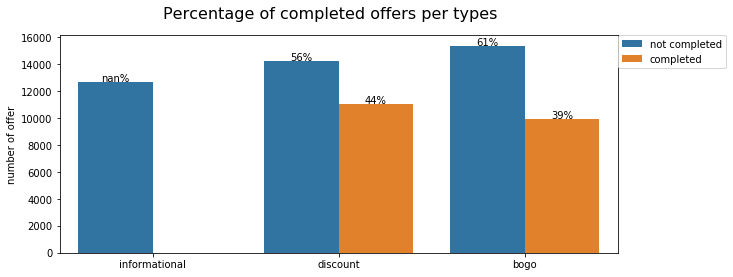

In [45]:
key_list = list(offer_dict.keys()) 
val_list = list(offer_dict.values())


hue_order = ['not completed', 'completed']

fig, ax = plt.subplots(figsize=(10, 4))
fig.suptitle('Percentage of completed offers per types', fontsize=16)
#sb.set_theme(style="darkgrid")

ax = sb.countplot(data = plot_data_df[plot_data_df['offer_type'] != 0], x = 'offer_type', hue = 'Class',  hue_order = hue_order)

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    if right:
        
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

plt.xticks(np.arange(3), key_list)
plt.xlabel('')
plt.ylabel('number of offer')
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)

Text(0.5, 0.98, 'Number of completed offers per channels')

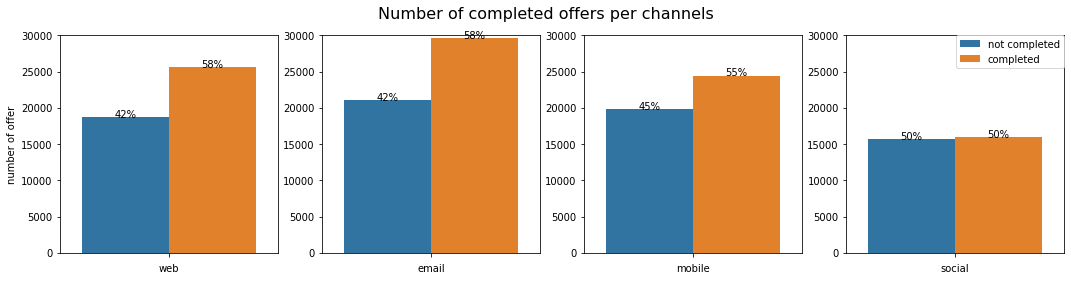

In [46]:
cat1_order = ['','web', 'email', 'mobile', 'social']

fig, ax = plt.subplots(figsize=(18, 4))

for i in range(len(cat1_order)):
    if i != 0:
        plt.subplot(1, 4, i)
        ax = sb.countplot(data = plot_data_df[(plot_data_df[cat1_order[i]] == 1) & (plot_data_df['offer_type'] != 1)], 
                          x = cat1_order[i], hue = 'Class')
        ax.get_legend().remove()
        
        plt.xticks(np.arange(1), [''])
        plt.ylim(0, 30000)
        
        if i==1:
            plt.ylabel('number of offer')
        else:
            plt.ylabel('')
            
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")
        

plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)
fig.suptitle('Number of completed offers per channels', fontsize=16)

Text(0.5, 0.98, 'Completed offers following the reward, the difficulty and the duration')

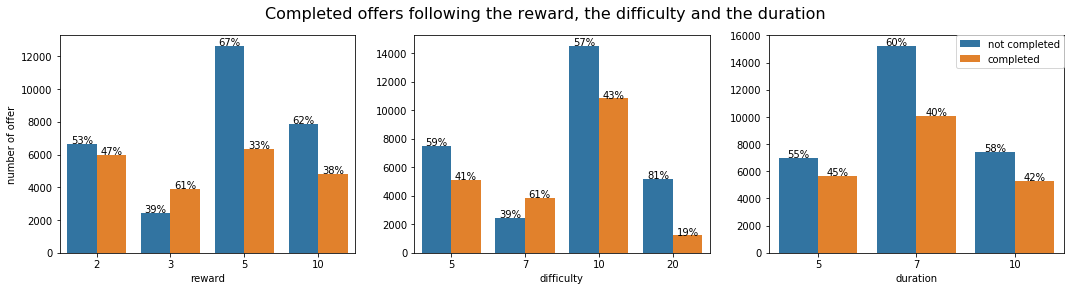

In [47]:
cat1_order = ['', 'reward', 'difficulty', 'duration']

fig, ax = plt.subplots(figsize=(18, 4))
#sb.set_theme(style="darkgrid")

for i in range(len(cat1_order)):
    if i != 0:
        plt.subplot(1, 3, i)
        ax = sb.countplot(data = plot_data_df[(plot_data_df['offer_type'] != 0) & (plot_data_df['offer_type'] != 1)], 
                          x = cat1_order[i], hue = 'Class', hue_order = hue_order)
        ax.get_legend().remove()
        
        if i==1:
            plt.ylabel('number of offer')
        else:
            plt.ylabel('')
            
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")
        

plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)
fig.suptitle('Completed offers following the reward, the difficulty and the duration', fontsize=16)

In [48]:
portfolio_clean_df

,reward,difficulty,duration,offer_type,web,email,mobile,social
1,10,10,7,3,0,1,1,1
2,10,10,5,3,1,1,1,1
3,0,0,4,1,1,1,1,0
4,5,5,7,3,1,1,1,0
5,5,20,10,2,1,1,0,0
6,3,7,7,2,1,1,1,1
7,2,10,10,2,1,1,1,1
8,0,0,3,1,0,1,1,1
9,5,5,5,3,1,1,1,1
10,2,10,7,2,1,1,1,0


In [49]:
# Creation of a radar chart based on the mean of the reward, the duration and difficulty for each type of offer

radar_char1_df = portfolio_clean_df[portfolio_clean_df['offer_type'] != 1].copy(deep=True)
radar_char1_df['offer'] = ['offer 1', 'offer 2','offer 4', 'offer 5', 
                           'offer 6','offer 8', 'offer 9', 'offer 10']

drop = ["web" , "email", "offer_type", "mobile", "social"]
radar_char1_df = radar_char1_df.drop(columns = drop)
radar_char1_df = radar_char1_df[['offer', 'reward', 'difficulty', 'duration']]
radar_char1_df = radar_char1_df.set_index(np.array([0,1,2,3,4,5,6,7]).reshape(-1))
radar_char1_df

,offer,reward,difficulty,duration
0,offer 1,10,10,7
1,offer 2,10,10,5
2,offer 4,5,5,7
3,offer 5,5,20,10
4,offer 6,3,7,7
5,offer 8,2,10,10
6,offer 9,5,5,5
7,offer 10,2,10,7


In [50]:
from math import pi

# Code taken from https://python-graph-gallery.com/392-use-faceting-for-radar-chart/

def make_spider(row, title, color):

    # number of variable
    categories=list(radar_char1_df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,5,row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(np.arange(0,12,3), ['0','4','8','12'], color="grey", size=10)
    plt.ylim(0,12)
    
    # Ind1
    values=radar_char1_df.loc[row].drop('offer').values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    # Add a title
    plt.title(radar_char1_df.at[row,'offer'], size=11, color=color, y=0)

Text(0.5, 0.98, 'Offer type regarding the reward, the duration and the difficulty (for BOGO and discount only)')

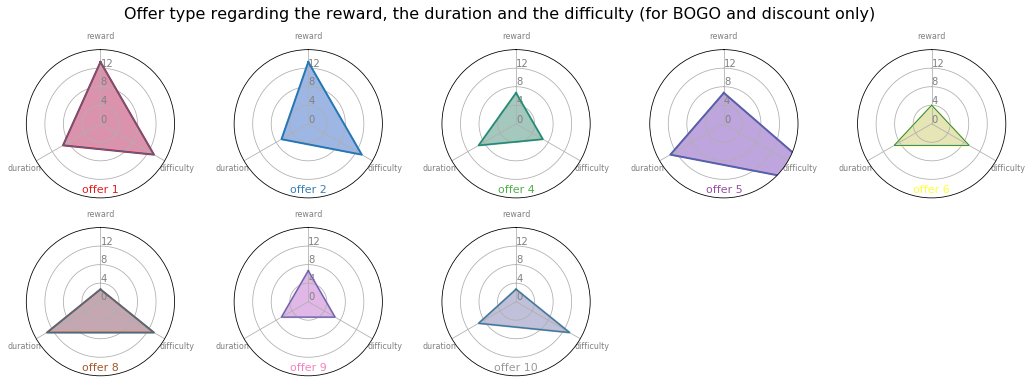

In [51]:
plt.figure(figsize=(18, 6))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(radar_char1_df.index))
 
# Loop to plot
for row in range(0, len(radar_char1_df.index)):
    make_spider(row=row, title=radar_char1_df['offer'][row], color=my_palette(row))

plt.suptitle('Offer type regarding the reward, the duration and the difficulty (for BOGO and discount only)', fontsize=16)

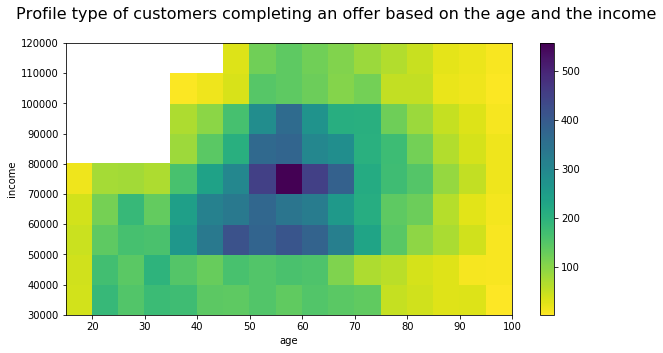

In [52]:
fig2, ax2 = plt.subplots(figsize=(10, 5))

bins_x = np.arange(15, 105, 5)
bins_y = np.arange(30000, plot_data_df['income'].max()+5000, 10000)

ax2 = plt.hist2d(data = plot_data_df[(plot_data_df['Class'] == 'completed')  
                                     & (plot_data_df['age'] != 118)
                                    & (plot_data_df['offer_type'] != 0)
                                    & (plot_data_df['offer_type'] != 1)], 
                               x = 'age', y = 'income', bins = [bins_x, bins_y], 
                               cmap = 'viridis_r', cmin = 0.5)

plt.colorbar()
plt.xlabel('age')
plt.ylabel('income')

fig2 = fig2.suptitle('Profile type of customers completing an offer based on the age and the income', fontsize=16)

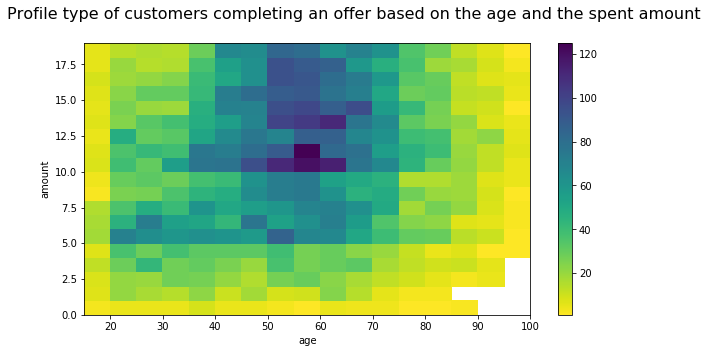

In [53]:
fig3, ax3 = plt.subplots(figsize=(10, 5))

bins_x = np.arange(15, 105, 5)
bins_y = np.arange(0, 20, 1)

ax3 = plt.hist2d(data = plot_data_df[(plot_data_df['Class'] == 'completed')  
                                     & (plot_data_df['age'] != 118)
                                    & (plot_data_df['offer_type'] != 0)
                                    & (plot_data_df['offer_type'] != 1)], 
                               x = 'age', y = 'amount', bins = [bins_x, bins_y], 
                               cmap = 'viridis_r', cmin = 0.5)

plt.colorbar()
plt.xlabel('age')
plt.ylabel('amount')

fig3 = fig3.suptitle('Profile type of customers completing an offer based on the age and the spent amount', fontsize=16)

In [ ]:
#sb.displot(data=plot_data_df[plot_data_df['Class'] == 'completed'], x="amount")
#plt.xscale('log')

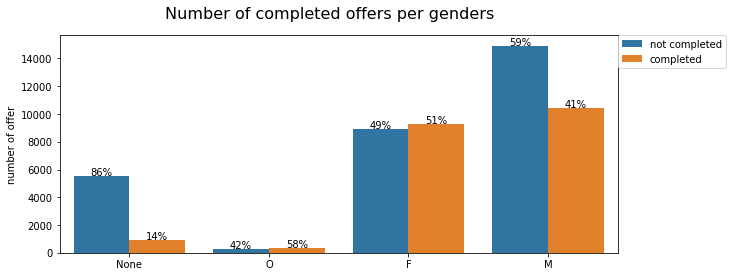

In [55]:
key_list = list(gender_dict.keys()) 
val_list = list(gender_dict.values())

hue_order = ['not completed', 'completed']

fig4, ax4 = plt.subplots(figsize=(10, 4))
fig4.suptitle('Number of completed offers per genders', fontsize=16)
#sb.set_theme(style="darkgrid")

ax = sb.countplot(data = plot_data_df[(plot_data_df['offer_type'] != 0)
                                     & (plot_data_df['offer_type'] != 0)
                                    & (plot_data_df['offer_type'] != 1)], 
                  x = 'gender', hue = 'Class',  hue_order = hue_order)

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    if right:
        
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

plt.xticks(np.arange(4), key_list)
plt.xlabel('')
plt.ylabel('number of offer')
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)

In [56]:
plot_data_df.head()

,received,viewed,completed,completed before viewed,amount,reward,person,offer,pers-offer,difficulty,...,offer_type,web,email,mobile,social,age,became member on,gender,income,Class
pers-offer-time,,,,,,,,,,,,,,,,,,,,,
3-4-0,1,1,1,0,19.89,5,3,4,3-4,5,...,3,1,1,1,0,75,20170509,2,100000.000000,completed
4-5-0,3,2,0,0,0.00,5,4,5,4-5,20,...,2,1,1,0,0,118,20170804,0,65404.991568,not completed
5-10-0,1,1,0,0,0.00,2,5,10,5-10,10,...,2,1,1,1,0,68,20180426,3,70000.000000,not completed
6-7-0,2,2,0,0,0.00,2,6,7,6-7,10,...,2,1,1,1,1,118,20170925,0,65404.991568,not completed
7-2-0,1,1,0,0,0.00,10,7,2,7-2,10,...,3,1,1,1,1,118,20171002,0,65404.991568,not completed


In [57]:
became_member_on_dict = {}
plot_completed_df = plot_data_df[plot_data_df['Class'] == 'completed'].copy(deep = True)

# initialisation of the keys
for i in plot_completed_df['became member on']:
    became_member_on_dict[i] = 0

# find how many time a offer has been completed   
for i in plot_completed_df['became member on']:  
    became_member_on_dict[i] += 1

    
date_list = list()

for key in became_member_on_dict.keys():
    date = str(key)[0:4] + '-' + str(key)[4:6] + '-' + str(key)[6:8]
    date_list.append(date)
    
completed_list = list(became_member_on_dict.values())

became_member_on_df = pd.DataFrame(completed_list, index = date_list, columns = ['completed'])
became_member_on_df = became_member_on_df.sort_index()
became_member_on_df

,completed
2013-07-29,24
2013-07-30,41
2013-07-31,5
2013-08-01,18
2013-08-02,23
...,...
2018-07-22,124
2018-07-23,56
2018-07-24,66
2018-07-25,85


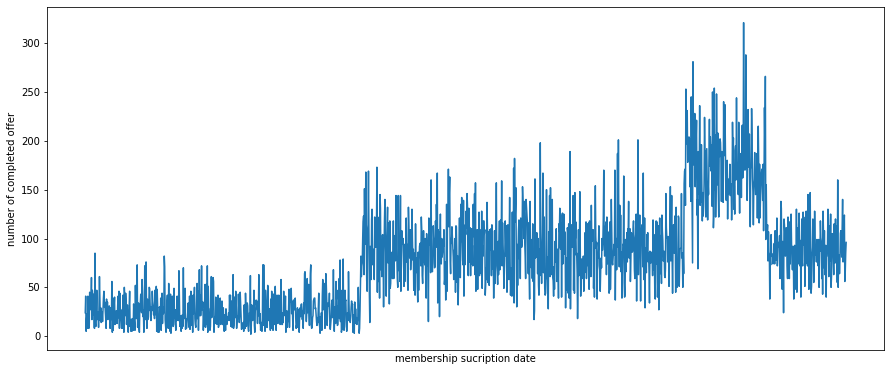

In [58]:
import matplotlib.dates as mdates 

fig5, ax5 = plt.subplots(figsize=(15,7))

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.plot(became_member_on_df)

plt.gcf().autofmt_xdate()
plt.xlabel('membership sucription date')
plt.ylabel('number of completed offer')
plt.show()

## Implementation

In [59]:
import sklearn.model_selection

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data_input_df, class_df, test_size=0.33)


In [60]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42402 entries, 6252-1-168 to 3298-1-504
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount            42402 non-null  float64
 1   reward            42402 non-null  float64
 2   difficulty        42402 non-null  float64
 3   duration          42402 non-null  float64
 4   web               42402 non-null  int64  
 5   email             42402 non-null  int64  
 6   mobile            42402 non-null  int64  
 7   social            42402 non-null  int64  
 8   age               42402 non-null  float64
 9   became member on  42402 non-null  float64
 10  income            42402 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 3.9+ MB


In [61]:
Y_train

,Class
pers-offer-time,
6252-1-168,1
10012-7-408,0
11619-2-0,0
746-5-0,0
7943-7-0,1
...,...
12853-7-576,0
6838-2-576,0
10340-6-408,0


In [62]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20886 entries, 9797-3-504 to 12682-7-0
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount            20886 non-null  float64
 1   reward            20886 non-null  float64
 2   difficulty        20886 non-null  float64
 3   duration          20886 non-null  float64
 4   web               20886 non-null  int64  
 5   email             20886 non-null  int64  
 6   mobile            20886 non-null  int64  
 7   social            20886 non-null  int64  
 8   age               20886 non-null  float64
 9   became member on  20886 non-null  float64
 10  income            20886 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 1.9+ MB


In [63]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker import LinearLearner

# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

# specify output
prefix = 'next_best_offer'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_path,
                                sagemaker_session=sagemaker_session,
                                epochs=15)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [64]:
# create RecordSet of training data
train_features_np = np.array(X_train).astype('float32')
train_labels_np = np.array(Y_train).flatten().astype('float32')

formatted_train_data = linear.record_set(train_features_np, labels = train_labels_np)

In [65]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-10 23:34:57 Starting - Starting the training job...
2020-12-10 23:35:22 Starting - Launching requested ML instancesProfilerReport-1607643297: InProgress
.........
2020-12-10 23:36:43 Starting - Preparing the instances for training.........
2020-12-10 23:38:24 Downloading - Downloading input data
2020-12-10 23:38:24 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/10/2020 23:38:43 INFO 140410694833984] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': 

In [66]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!CPU times: user 313 ms, sys: 28.2 ms, total: 341 ms
Wall time: 8min 32s


In [67]:
Y_test

,Class
pers-offer-time,
9797-3-504,0
15279-4-0,0
1177-3-336,0
14235-7-576,1
8956-10-168,1
...,...
4909-9-576,0
16155-3-576,0
4276-3-336,0


In [68]:
# test one prediction
test_x_np = np.array(X_test).astype('float32')
result = linear_predictor.predict(test_x_np[1])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.11873790621757507
    }
  }
}
]


In [69]:
# this code is the same as the provided helper from the Fraud_Detection_Exercise

# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [70]:
test_features_np = np.array(X_test).astype('float32')
test_labels_np = np.array(Y_test).flatten().astype('float32')

print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(linear_predictor, 
                   test_features_np.astype('float32'), 
                   test_labels_np, 
                   verbose=True)

Metrics for simple, LinearLearner.

prediction (col)    0.0   1.0
actual (row)                 
0.0               11859  2050
1.0                1495  5482

Recall:     0.786
Precision:  0.728
Accuracy:   0.830



In [71]:
# this code is the same as the provided helper from the Fraud_Detection_Exercise
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [72]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2020-12-10-23-39-40-498


## Refinement ##

In [78]:
linear_refined2 = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_path,
                                sagemaker_session=sagemaker_session,
                                epochs=15,
                                binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                                target_recall=0.98,
                                positive_example_weight_mult = 'balanced')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [79]:
%%time 
# train the estimator on formatted training data witht the refined model
linear_refined2.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-11 00:03:28 Starting - Starting the training job...ProfilerReport-1607645008: InProgress
...
2020-12-11 00:04:24 Starting - Launching requested ML instances......
2020-12-11 00:05:25 Starting - Preparing the instances for training.........
2020-12-11 00:06:55 Downloading - Downloading input data...
2020-12-11 00:07:28 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/11/2020 00:07:33 INFO 140553801070400] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'a

In [80]:
%%time 
# deploy and create a predictor
linear_refined_predictor2 = linear_refined2.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 342 ms, sys: 24.5 ms, total: 366 ms
Wall time: 9min 32s


In [81]:
test_features_np = np.array(X_test).astype('float32')
test_labels_np = np.array(Y_test).flatten().astype('float32')

print('Metrics for simple, LinearLearner.\n')

# get metrics for the refined linear predictor
metrics = evaluate(linear_refined_predictor2, 
                   test_features_np.astype('float32'), 
                   test_labels_np, 
                   verbose=True)

Metrics for simple, LinearLearner.

prediction (col)   0.0   1.0
actual (row)                
0.0               8940  4969
1.0                151  6826

Recall:     0.978
Precision:  0.579
Accuracy:   0.755



In [82]:
# delete the predictor endpoint 
delete_endpoint(linear_refined_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Already deleted: linear-learner-2020-12-10-23-52-49-007


In [73]:
linear_refined = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_path,
                                sagemaker_session=sagemaker_session,
                                epochs=15,
                                binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                                target_recall=0.85,
                                positive_example_weight_mult = 'balanced')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [74]:
%%time 
# train the estimator on formatted training data witht the refined model
linear_refined.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-10 23:48:36 Starting - Starting the training job...
2020-12-10 23:48:59 Starting - Launching requested ML instancesProfilerReport-1607644116: InProgress
......
2020-12-10 23:50:00 Starting - Preparing the instances for training.........
2020-12-10 23:51:21 Downloading - Downloading input data...
2020-12-10 23:52:02 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/10/2020 23:52:00 INFO 140035041101632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto'

In [75]:
%%time 
# deploy and create a predictor
linear_refined_predictor = linear_refined.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------------!CPU times: user 388 ms, sys: 16.4 ms, total: 404 ms
Wall time: 10min 34s


In [76]:
test_features_np = np.array(X_test).astype('float32')
test_labels_np = np.array(Y_test).flatten().astype('float32')

print('Metrics for simple, LinearLearner.\n')

# get metrics for the refined linear predictor
metrics = evaluate(linear_refined_predictor, 
                   test_features_np.astype('float32'), 
                   test_labels_np, 
                   verbose=True)

Metrics for simple, LinearLearner.

prediction (col)    0.0   1.0
actual (row)                 
0.0               11637  2272
1.0                 980  5997

Recall:     0.860
Precision:  0.725
Accuracy:   0.844



In [77]:
# delete the predictor endpoint 
delete_endpoint(linear_refined_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2020-12-10-23-52-49-007
